# Test suite for Project 1


In [171]:
from proj1_helpers import *
from implementations import *
from auxiliary import *
import pickle
import matplotlib.pyplot as plt
import datetime
import random

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Data loading

* Training set : `../data/train.csv`

In [119]:
train_path = '../data/train.csv'

In [120]:
easy_data_set = False # changer pour sélectionner un set de dim (1000,2) ou le vrai set

if easy_data_set:
    ids, y, X = load_easy_data(sub_sample=False)
else:
    ids, y, X = load_csv_data(train_path)
    # Only 100% clean data
    ranges = [(1,4), (7,12), (13,23), (29,30)]
    keep_idx = build_idx(ranges)
    X = X[:,keep_idx]

x, mean_x, std_x = standardize(X)
tx = np.c_[np.ones((y.shape[0], 1)), x]
tx = build_poly(x, 1)

N = x.shape[0]
D = x.shape[1]

In [121]:
# to check that we eliminated all unecessary features
clean_data = [x for x in X if not -999. in x]
len(clean_data)/len(X)*100 # percent

100.0

* Testing set : `../data/test.csv`

In [122]:
test_path  = '../data/test.csv'

In [123]:
# takes time, run only when needed
ids_te, y_te, X_te = load_csv_data(test_path)

ranges = [(1,4), (7,12), (13,23), (29,30)]
keep_idx = build_idx(ranges)
X_te = X_te[:,keep_idx]

x_te, mean_x_te, std_x_te = standardize(X_te)
tx_te = build_poly(x_te, 1)

#### Data cache

In [3]:
# Long, run only if necessary
# train_data = load_csv_data(train_path)

In [4]:
# Long, run only if necessary
# test_data = load_csv_data(test_path)

In [5]:
# Save the data as pickles for more efficient reloading
# Only run once to generate the pickle !
# pickle.dump(test_data, open( 'test.p', 'wb' ))
# pickle.dump(train_data, open( 'train.p', 'wb' ))

In [6]:
# loading the pickle back 
#train_data = pickle.load(open( 'train.p', 'rb' ))
#test_data = pickle.load(open( 'test.p', 'rb' ))

## Exploratory

* Describe / Discover the data
* Describe / Characterise the features

In [7]:
## Data dimensions
print("There are {} samples.".format(len(train_data[0])))

There are 250000 samples.


The training data is defined as a set $D = \{ (y_i, \mathbf{x}_i, w_i) \}$ with :
* $y_i \in \{+1,-1\}$ is the label (signal = `+1` or noise = `-1`)
* $\mathbf{x}_i \in \!R^d$ is a $d$-dimensional feature vector
* $w_i \in \!R^+$ is a non-negative weight

Note that $\sum_{i\in\mathcal{S}} w_i = N_s$ and $\sum_{i\in\mathcal{B}} w_i = N_b$ which are the *expected total number of signal and background events (resp.)*. This gives an estimate of how many events we should expect to classify for each class.

In [8]:
# The feature vector shape is 
train_data[2].shape

(250000, 30)

In [9]:
# Which means we have d features :
d = train_data[2].shape[1]
d

30

In [10]:
ids = train_data[0]
labels  = train_data[1]
x_train = train_data[2]

if(labels.ndim<2):
    labels = np.expand_dims(labels, axis=1) # expand the labels as array

In [11]:
test_ids = train_data[0]
test_labels  = train_data[1]
test_x = train_data[2]

if(test_labels.ndim<2):
    test_labels = np.expand_dims(test_labels, axis=1) # expand the labels as array

Information about the features :

* Variables are floating point unless specified otherwise.
* All azimuthal φ angles are in radian in the [−π, +π[ range.
* Energy, mass, momentum are all in GeV
* All other variables are unit less
* **Undefined values are `-999.0`**

There are `primitive` (prefixed with `PRI`) values, directly measured from the collision, and `derived` (prefixed with `DER`) values which were computed from the primitive values.

In [12]:
PRI_features = x_train[:,:13]
DER_features = x_train[:,13:]
print(len(PRI_features[0]), len(DER_features[0]))

13 17


## Data processing

> This part is exploratory and informed the processing step done when loading the data. 

> !!!!!!!!!!!!!!!!!!!!!!!!!!! DO NOT RUN AGAIN !!!!!!!!!!!!!!!!!!!!!!!!!!

* Split test / train
* Clean useless features
* [Scale / process data](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) (e.g. scaling)

How much data is perfectly clean ?

In [13]:
clean_data = [x for x in x_train if not -999. in x]
len(clean_data)/len(x_train)*100 # percent

27.245599999999996

How much data is clean in the primitive or derived classes ?

In [14]:
PRI_clean_data = [x for x in PRI_features if not -999. in x]
len(PRI_clean_data)/len(PRI_features)*100 # percent

27.245599999999996

In [15]:
DER_clean_data = [x for x in DER_features if not -999. in x]
len(DER_clean_data)/len(DER_features)*100 # percent

29.0172

The percentage is almost the same ! This means there was not a lot of treatment error, using only `PRI` or only `DER` data won't make the data cleaner (but it might help reduce the complexity of the model ;) )

Are there classes that contain a high probability of dirty data ?

In [16]:
per_feature_stats = []
for i in range(d):
    sz = len(x_train[:,i])
    clean_ft = [x for x in x_train[:,i] if (x != -999.)] # c pa bo ... :'(
    per_feature_stats.append(len(clean_ft) / sz * 100)

(array([  7.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,   0.,  19.]),
 array([  29.0172 ,   36.11548,   43.21376,   50.31204,   57.41032,
          64.5086 ,   71.60688,   78.70516,   85.80344,   92.90172,  100.     ]),
 <a list of 10 Patch objects>)

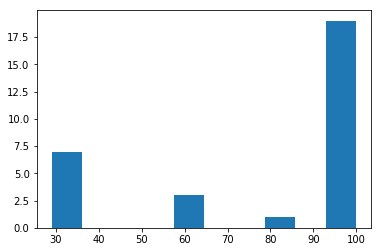

In [17]:
plt.hist(per_feature_stats)

This gives a pretty good indication of the features that should be pruned from the data ! Notably :
* `x_train[:, 4: 7]` (which are resp. `DER_deltaeta_jet_jet`, `DER_mass_jet_jet`, `DER_prodeta_jet_jet`)
* `x_train[:,12]` (which is `DER_lep_eta_centrality`)
* `x_train[:,26:29]` (which is the `PRI_jet_subleading_{pt,eta,phi}`)

We can also consider removing `x_train[:,23:26]` (`PRI_jet_leading_{pt,eta,phi}`) which only has ~60% clean data ...

In [18]:
# Only 100% clean data
ranges = [(1,4), (7,12), (13,23), (29,30)]
keep_idx = build_idx(ranges)
x_train_full_clean = x_train[:,keep_idx]

In [19]:
# With feature 1 and 23-26
ranges = [(0,4), (7,12), (13,26), (29,30)]
keep_idx = build_idx(ranges)
x_train_partial_clean = x_train[:,keep_idx]

In [20]:
# With features 1-3
ranges = [(1,4)]
keep_idx = build_idx(ranges)
x_train_small_features = x_train[:,keep_idx]

Check the size of the sets, and expand the sets

In [21]:
print(x_train.shape)
print(x_train_full_clean.shape)
print(x_train_partial_clean.shape)
print(x_train_small_features.shape)

tx_train = np.c_[np.ones((labels.shape[0], 1)), x_train]
tx_train_full_clean = np.c_[np.ones((labels.shape[0], 1)), x_train_full_clean]
tx_train_partial_clean = np.c_[np.ones((labels.shape[0], 1)), x_train_partial_clean]
tx_train_small_features = np.c_[np.ones((labels.shape[0], 1)), x_train_small_features]

(250000, 30)
(250000, 19)
(250000, 23)
(250000, 3)


Create a very small set for testing the algorithms

In [22]:
# Needs to be randomly sampled !
sample_small_set = 1000

small_tx_train = tx_train_full_clean[:sample_small_set, :]
small_labels = labels[:sample_small_set].flatten()

dim = small_tx_train.shape[1]


Scale the training data

In [23]:
small_tx_std, mean_tx, std_tx = standardize(small_tx_train)

In [24]:
mean_tx, std_tx, np.mean(small_tx_std), np.std(small_tx_std)

(38.333962050000004, 73.500211504812071, -5.6843418860808016e-17, 1.0)

Create some testing data

In [25]:
subset_x_test_full_clean = test_x[sample_small_set:2*sample_small_set,:]
subset_test_labels = test_labels[sample_small_set:2*sample_small_set].flatten()

In [26]:
small_test_x_std, mean_test_x, std_test_x = standardize(small_tx_train)

> Okay you can run again :) 

## Training

* **Train** the model with the different learning algorithms
    * `least_squares`
    * `least_squares_GD`
    * `least_squares_SGD`
    * `ridge_regression`
    * `logistic_regression`
    * `reg_logistic_regression`

In [172]:
accuracy_per_algorithm = {}

#### Least squares

In [173]:
w_LS, loss = least_squares(y,tx)
_, err_tr = compute_classification_error(y, tx, w_LS)
_, err_te = compute_classification_error(y_te, tx_te, w_LS)

In [174]:
accuracy_tr = 1 - err_tr
accuracy_te = 1 - err_te
print("method   -- Least Squares")
print()
print("\t -- Accuracy train = %.2f percent " % (accuracy_tr*100))
print("\t -- Accuracy test  = %.2f percent " % (accuracy_te*100))

method   -- Least Squares

	 -- Accuracy train = 39.01 percent 
	 -- Accuracy test  = 87.65 percent 


In [175]:
accuracy_per_algorithm['LS'] = { 
    'accuracy' : {
        'train' : accuracy_tr,
        'test'  : accuracy_te,
        'loss'  : loss,
    }
}

#### Least Squares with Gradient Descent

In [176]:
w_initial = np.array([0]*(D+1))
max_iters = 100
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.5]
losses = []
ws = [] 

for gamma in gammas:
    w, loss = least_squares_GD(y, tx, w_initial, max_iters, gamma)
    losses.append(loss)
    ws.append(w)

In [177]:
w_LS_GD = ws[np.argmin(losses)]
_, err_tr = compute_classification_error(y, tx, w_LS_GD)
_, err_te = compute_classification_error(y_te, tx_te, w_LS_GD)

In [178]:
accuracy_tr = 1 - err_tr
accuracy_te = 1 - err_te
print("method   -- Least Squares GD")
print("params   -- gamma = {}, max_iters = {}".format(gammas[0], max_iters))
print()
print("\t -- Accuracy train = %.2f percent " % (accuracy_tr*100))
print("\t -- Accuracy test  = %.2f percent " % (accuracy_te*100))

method   -- Least Squares GD
params   -- gamma = 1e-09, max_iters = 100

	 -- Accuracy train = 38.54 percent 
	 -- Accuracy test  = 95.20 percent 


In [179]:
accuracy_per_algorithm['LS_GD'] = { 
    'accuracy' : {
        'train' : accuracy_tr,
        'test'  : accuracy_te,
        'loss'  : loss,
    }
}

#### least_squares_SGD

In [180]:
w_initial = np.array([0]*(D+1))
max_iters = 1000
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
batch_size = 1
losses = []
ws = []

for gamma in gammas:
    sgd_ws, sgd_losses = least_squares_SGD(y, tx, w_initial, batch_size, max_iters, gamma)
    losses.append(sgd_losses)
    ws.append(sgd_ws)

In [181]:
w_LS_SGD = ws[np.argmin(losses)]
_, err_tr = compute_classification_error(y, tx, w_LS_SGD)
_, err_te = compute_classification_error(y_te, tx_te, w_LS_SGD)

In [182]:
accuracy_tr = 1 - err_tr
accuracy_te = 1 - err_te
print("method   -- Least Squares SGD")
print("params   -- gamma = {}, max_iters = {}".format(gammas[0], max_iters))
print()
print("\t -- Accuracy train = %.2f percent " % (accuracy_tr*100))
print("\t -- Accuracy test  = %.2f percent " % (accuracy_te*100))

method   -- Least Squares SGD
params   -- gamma = 1e-09, max_iters = 1000

	 -- Accuracy train = 40.89 percent 
	 -- Accuracy test  = 91.36 percent 


In [183]:
accuracy_per_algorithm['LS_SGD'] = { 
    'accuracy' : {
        'train' : accuracy_tr,
        'test'  : accuracy_te,
        'loss'  : loss,
    }
}

#### Polynomial Least-Squares Regression

In [184]:
degrees = [1, 3, 7, 12]
losses = []
ws = []
        
for ind, degree in enumerate(degrees):
    phi = build_poly(x, degree)  
        
    w_degree_LS, loss_degree_LS = least_squares(y, phi)
        
    losses.append(loss_degree_LS)
    ws.append(w_degree_LS)

In [185]:
deg_POLY_LS = degrees[np.argmin(losses)]
poly_tr = build_poly(x, deg_POLY_LS)
poly_te = build_poly(x_te, deg_POLY_LS)

In [186]:
w_POLY_LS = ws[np.argmin(losses)]
_, err_tr = compute_classification_error(y, poly_tr, w_POLY_LS)
_, err_te = compute_classification_error(y_te, poly_te, w_POLY_LS)

In [187]:
accuracy_tr = 1 - err_tr
accuracy_te = 1 - err_te
print("method   -- Polynomial Least-Squares")
print("params   -- degree = {}".format(deg_POLY_LS))
print()
print("\t -- Accuracy train = %.2f percent " % (accuracy_tr*100))
print("\t -- Accuracy test  = %.2f percent " % (accuracy_te*100))

method   -- Polynomial Least-Squares
params   -- degree = 12

	 -- Accuracy train = 45.62 percent 
	 -- Accuracy test  = 79.82 percent 


In [188]:
accuracy_per_algorithm['LS_Poly'] = { 
    'accuracy' : {
        'train' : accuracy_tr,
        'test'  : accuracy_te,
        'loss'  : loss,
    }
}

#### ridge_regression


In [189]:
lambdas = np.logspace(-10, 0, 15)

ratio = 0.2
degree = 3

# split the data, and return train and test data
x_train, x_test, y_train, y_test = split_data(x, y, ratio)
    
# form train and test data with polynomial basis function
phi_train = build_poly(x_train, degree)
phi_test = build_poly(x_test, degree)
    
rmse_tr = []
rmse_te = []

ws = []
losses = []

for ind, lambda_ in enumerate(lambdas):
    w, loss = ridge_regression(y_train, phi_train, lambda_)
    
    ws.append(w)
    losses.append(loss)
    
    rmse_tr.append(compute_loss(y_train,phi_train,w))
    rmse_te.append(compute_loss(y_test,phi_test,w))

    print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, l=lambda_ ,tr=rmse_tr[ind], te=rmse_te[ind]))

proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.491
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.491
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.491
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.490
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.488
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.482
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.473
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.468
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.467
proportion=0.2, degree=3, lambda=0.000, Training RMSE=0.082, Testing RMSE=13.467
proportion=0.2, degree=3, lambda=0.001, Training RMSE=0.082, Testing RMSE=13.467
proportion=0.2, degree=3, lambda=0.007, Training RMSE=0.082, Testing RMSE=13.467
proportion=0.2, degree=3, la

In [190]:
deg_POLY_RR = degree
poly_tr = build_poly(x, deg_POLY_RR)
poly_te = build_poly(x_te, deg_POLY_RR)

In [191]:
w_RR = ws[np.argmin(losses)]
_, err_tr = compute_classification_error(y, poly_tr, w_RR)
_, err_te = compute_classification_error(y_te, poly_te, w_RR)

In [192]:
accuracy_tr = 1 - err_tr
accuracy_te = 1 - err_te
print("method   -- Ridge Regression")
print("params   -- lambda = {}, degree = {}".format(lambdas[np.argmin(losses)], deg_POLY_RR))
print()
print("\t -- Accuracy train = %.2f percent " % (accuracy_tr*100))
print("\t -- Accuracy test  = %.2f percent " % (accuracy_te*100))


method   -- Ridge Regression
params   -- lambda = 5.179474679231202e-10, degree = 3

	 -- Accuracy train = 42.00 percent 
	 -- Accuracy test  = 75.97 percent 


In [193]:
accuracy_per_algorithm['RR'] = { 
    'accuracy' : {
        'train' : accuracy_tr,
        'test'  : accuracy_te,
        'loss'  : loss,
    }
}

#### logistic_regression


In [194]:
w_initial = np.array([0]*(D+1))
max_iters = 1000
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.5]
losses = []
ws = []

for gamma in gammas:
    w, loss = logistic_regression(y, tx, w_initial, max_iters, gamma)
    losses.append(loss)
    ws.append(w)

/Users/Dylan/Documents/Cours/MT_MA3/Machine Learning/ML_Projects/project1/src/auxiliary.py:71: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1+np.exp(tx.dot(w))) - y*(tx.dot(w)))
/Users/Dylan/Documents/Cours/MT_MA3/Machine Learning/ML_Projects/project1/src/auxiliary.py:68: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-t))
/Users/Dylan/Documents/Cours/MT_MA3/Machine Learning/ML_Projects/project1/src/auxiliary.py:199: RuntimeWarning: invalid value encountered in double_scalars
  if abs(a-b) < threshold:


In [195]:
w_LR = ws[np.argmin(losses)]
_, err_tr = compute_classification_error(y, tx, w_LR)
_, err_te = compute_classification_error(y_te, tx_te, w_LR)

In [196]:
accuracy_tr = 1 - err_tr
accuracy_te = 1 - err_te
print("method   -- Logistic Regression")
print("params   -- gamma = {}".format(gammas[np.argmin(losses)]))
print()
print("\t -- Accuracy train = %.2f percent " % (accuracy_tr*100))
print("\t -- Accuracy test  = %.2f percent " % (accuracy_te*100))


method   -- Logistic Regression
params   -- gamma = 1e-06

	 -- Accuracy train = 73.87 percent 
	 -- Accuracy test  = 27.67 percent 


In [197]:
accuracy_per_algorithm['LR'] = { 
    'accuracy' : {
        'train' : accuracy_tr,
        'test'  : accuracy_te,
        'loss'  : loss,
    }
}

#### reg_logistic_regression

**TODO**

In [170]:
w_initial = np.array([0]*dim)
max_iters = 1000
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
lambdas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
losses = np.zeros([len(gammas), len(lambdas)])
ws = np.zeros([len(gammas), len(lambdas), small_tx_std.shape[1]])

small_labels_logistic =  np.copy(small_labels)
small_labels_logistic[small_labels_logistic == -1] = 0

for id0, gamma in enumerate(gammas):
    for id1, lambda_ in enumerate(lambdas):
        w, loss = reg_logistic_regression(small_labels_logistic, small_tx_std, lambda_, w_initial, max_iters, gamma) 
        losses[id0, id1] = loss
        ws[id0, id1, :] = w

# TODO : Formally get best params. In this case 1e-9 is the best so we'll see later
losses

NameError: name 'dim' is not defined

In [41]:
accuracy = compute_classification_error(subset_test_labels, small_test_x_std, ws[5][5])
print("method -- Least Squares GD")
print("params -- gamma = {}, lambda = {}, max_iters = {}".format(gammas[5], lambdas[5], max_iters))
print()
print("On a simple subset we obtain %.2f percent accuracy" % (accuracy*100))

method -- Least Squares GD
params -- gamma = 0.0001, lambda = 0.0001, max_iters = 1000

On a simple subset we obtain 40.60 percent accuracy


### CV on Least Squares

> Pour la beauté du geste


In [42]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # split the data, and return train and test data: TODO
    x_train, x_test, y_train, y_test = split_data(x, y, ratio)

    # form train and test data with polynomial basis function: TODO
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)
    
    # calcualte weight through least square.: TODO
    w,loss = least_squares(y_train, phi_train)

    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    loss_tr = compute_loss(y_train,phi_train,w)
    loss_te = compute_loss(y_test,phi_test,w)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=loss_tr, te=loss_te))

In [43]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)


## Cross validation with logistic regression


In [ ]:
def logistic_regression_split(x, y, degree, ratio, gamma, seed):
    """polynomial regression with different split ratios and different degrees."""
    # split the data, and return train and test data: TODO
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function: TODO
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)
    
    w_initial = np.array([0]*(phi_train.shape[1]))
    max_iters = 1000

    
    # calcualte weight through least square.: TODO
    w,loss_tr = logistic_regression(y_train, phi_train, w_initial, max_iters, gamma)
    
    loss_te = compute_logistic_loss(y_test, phi_test, w)
    # compute error and loss for train and test data
    error, ratio_error_train = compute_classification_error(y_train, phi_train, w)
    error, ratio_error_test = compute_classification_error(y_test, phi_test, w)

    
    print("proportion={p}, degree={d}, gamma={g}, Train loss, err_ratio=({tr:.3f},{er_tr:.3f}), Test loss, err_ratio=({te:.3f},{er_te:.3f})".format(
          p=ratio, d=degree, g=gamma, tr=loss_tr, te=loss_te, er_tr=ratio_error_train, er_te=ratio_error_test))
    return w, ratio_error_train, ratio_error_test


In [ ]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.8, 0.5, 0.1]
gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.5]

ws = []
ratio_err_trains = []
ratio_err_tests = []

for split_ratio in split_ratios:
    for degree in degrees:
        for gamma in gammas:
            w, ratio_error_train, ratio_error_test = logistic_regression_split(x, y, degree, split_ratio, gamma, seed)
            ws.append(w)
            ratio_err_trains.append(ratio_error_train)
            ratio_err_tests.append(ratio_error_test)
            

## Cross validation with regularized logistic regression


In [ ]:
def reg_logistic_regression_split(x, y, degree, ratio, gamma, lambda_, seed):
    """polynomial regression with different split ratios and different degrees."""
    # split the data, and return train and test data: TODO
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function: TODO
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)
    
    w_initial = np.array([0]*(phi_train.shape[1]))
    max_iters = 1000

    
    # calcualte weight through logistic regression
    w, loss_tr = reg_logistic_regression(y_train, phi_train, lambda_, w_initial, max_iters, gamma, SGD=False)
    
    loss_te = compute_logistic_loss(y_test, phi_test, w)
    # compute error and loss for train and test data
    error, ratio_error_train = compute_classification_error(y_train, phi_train, w)
    error, ratio_error_test = compute_classification_error(y_test, phi_test, w)

    
    print("prop={p}, deg={d}, g={g:.3f}, l={l:.3f}, Train loss, err_ratio=({tr:.3f},{er_tr:.3f}), Test loss, err_ratio=({te:.3f},{er_te:.3f})".format(
          p=ratio, d=degree, g=gamma, l=lambda_, tr=loss_tr, te=loss_te, er_tr=ratio_error_train, er_te=ratio_error_test))
    return w, ratio_error_train, ratio_error_test


In [ ]:
seed = 6
degrees = [1, 7]
split_ratios = [0.9]
gammas = [1e-9, 1e-5, 1e-1, 0.5]
lambdas = np.logspace(-5, 0, 2)

ws = []
ratio_err_trains = []
ratio_err_tests = []

for split_ratio in split_ratios:
    for degree in degrees:
        for gamma in gammas:
            for lambda_ in lambdas:
                w, ratio_error_train, ratio_error_test = reg_logistic_regression_split(x, y, degree, split_ratio, gamma, lambda_, seed)
                ws.append(w)
                ratio_err_trains.append(ratio_error_train)
                ratio_err_tests.append(ratio_error_test)
            

In [ ]:
w_reg_log_reg = ws[np.argmin(ratio_err_tests)]
np.argmin(ratio_err_tests)

## Results

* Plot the train / test accuracies for the best set of algorithm + parameters

In [ ]:
y_te = predict_labels(w_reg_log_reg, tx_te)
y_te[y_te==0] = -1
create_csv_submission(ids_te, y_te, 'submission.csv')